# Hypothesis: I can figure out how clean a restaurant is by its yelp ratings. Possibly by also including type of food and location of restaurant. 
# Null hypothesis: A restaurants inspection grade and yelp ratings are not correlated at all

In [1]:
import numpy as np
import pandas as pd
import os.path
import json

import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import cross_val_score

import sklearn.metrics as skmetrics

%matplotlib inline



/Users/allandong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Gathering

Reading NYC Restaurant Inspection data into DataFrame to grab restaurant title/address to generate appropriate yelp urls for futures scraping

In [2]:
nyccsv = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/DOHMH_New_York_City_Restaurant_Inspection_Results.csv'

df = pd.read_csv(nyccsv)

cols = ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE_DESC',
           'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE', 'VIOLATION_DESC', 'CRITICAL_FLAG',
           'SCORE', 'GRADE', 'GRADE_DATE', 'RECORD_DATE', 'INSPECTION_TYPE']
df.columns = cols




Yelp URLs are formulaic, by title and address. Generate Yelp URLs for scraping with scrapy.

In [3]:
df['ADDRESS'] = df.BUILDING + " " + df.STREET + " " + df.BORO

def yelp_url_gen(row):
    # yelp_url_gen:
    #     Yelp search urls are formulatic based upon "Find" and "Location" inserted values -
    #   so, I can generate what the urls would be if I serached by restaurant title and
    #   restaurant address

    title1 = row['DBA'].replace(" ", "+")
    address1 = row['ADDRESS'].replace(" ", "+")
    return "https://www.yelp.com/search?find_desc={title1}&find_loc={address1}".format(title1=title1, address1=address1)

df_clean = df.dropna(axis=0, how='any')
df_clean['URL'] = df_clean.apply(yelp_url_gen, axis = 1)

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
df_clean.ZIPCODE = df_clean.loc[:, 'ZIPCODE'].astype(int)
df_clean.ZIPCODE = df_clean.loc[:, 'ZIPCODE'].astype(str)

/Users/allandong/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [5]:
df_clean.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESC', 'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE',
       'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE', 'GRADE', 'GRADE_DATE',
       'RECORD_DATE', 'INSPECTION_TYPE', 'ADDRESS', 'URL'],
      dtype='object')

# Add Yelp Data, Data Cleaning

df_yelp = Read in Yelp data as a DataFrame, and add a 'RATINGS' column that just has the rating number

In [6]:
yelp = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/yelp.csv'

df_yelp= pd.read_csv(yelp)

yelp_cols = ['URL', 'YELP_RATINGS']
df_yelp.columns = yelp_cols

df_yelp = df_yelp[df_yelp['YELP_RATINGS'] != 'yelp_ratings']

def get_num(row):
    return float(row['YELP_RATINGS'].split()[0])

df_yelp['RATINGS'] = df_yelp.apply(get_num, axis=1)


df_ex_pre_raw = Concating df_short and df_yelp and with NaN's dropped

In [7]:
df_ex_pre_raw= pd.merge(df_clean, df_yelp, how='left',on='URL')

df_ex_pre_raw = df_ex_pre_raw.drop_duplicates().dropna(axis=0, how='any')

In [8]:
df_ex_pre_raw.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESC', 'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE',
       'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE', 'GRADE', 'GRADE_DATE',
       'RECORD_DATE', 'INSPECTION_TYPE', 'ADDRESS', 'URL', 'YELP_RATINGS',
       'RATINGS'],
      dtype='object')

In [9]:
df_ex_pre = df_ex_pre_raw.drop(['BUILDING', 
                              'STREET', 
                              'PHONE',
                              'ADDRESS',
                              'URL',
                              'YELP_RATINGS'
                                 ], 1)

In [10]:
df_ex_pre.INSPECTION_DATE = pd.to_datetime(df_ex_pre.INSPECTION_DATE)

In [11]:
df_ex_pre.columns

Index(['CAMIS', 'DBA', 'BORO', 'ZIPCODE', 'CUISINE_DESC', 'INSPECTION_DATE',
       'ACTION', 'VIOLATION_CODE', 'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE',
       'GRADE', 'GRADE_DATE', 'RECORD_DATE', 'INSPECTION_TYPE', 'RATINGS'],
      dtype='object')

### df_ex is now my base dataframe 

In [12]:
df_ex = df_ex_pre.drop(['INSPECTION_DATE'], 1)

df_ex = df_ex[df_ex['GRADE'] != 'Not Yet Graded']


In [13]:
df_ex.columns

Index(['CAMIS', 'DBA', 'BORO', 'ZIPCODE', 'CUISINE_DESC', 'ACTION',
       'VIOLATION_CODE', 'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE', 'GRADE',
       'GRADE_DATE', 'RECORD_DATE', 'INSPECTION_TYPE', 'RATINGS'],
      dtype='object')

### 1. Linear Regression - Log_Score, Ratings, Critical_Flag
### Create df for linear regression

In [14]:
df_linear1 = df_ex.drop(['CAMIS',
                         'GRADE',
                         'DBA',
                         'VIOLATION_CODE',
                         'ZIPCODE',
                         'BORO',
                         'CUISINE_DESC',
                         'VIOLATION_DESC',
                         'ACTION',
                         'INSPECTION_TYPE',
                         'GRADE_DATE',
                         'RECORD_DATE'
                         ], 1)

In [15]:
df_linear2 = df_linear1[df_linear1.SCORE >0]

df_linear2['Log_Score'] = df_linear2.loc[:,'SCORE'].apply(np.log)

df_linear2 = df_linear2.drop(['SCORE'], 1)


/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df_lin2 = pd.get_dummies(df_linear2, drop_first = True, columns = [#'ZIPCODE', 
                                                    #'BORO', 
                                                    #'CUISINE_DESC', 
                                                    'CRITICAL_FLAG'])
df_lin2.columns

Index(['RATINGS', 'Log_Score', 'CRITICAL_FLAG_Not Critical'], dtype='object')

In [17]:
df_lin2 = df_lin2[['Log_Score', 'RATINGS', 'CRITICAL_FLAG_Not Critical']]

In [18]:
df_lin2.head(2)

,Log_Score,RATINGS,CRITICAL_FLAG_Not Critical
0,3.295837,2.5,0
41,2.197225,3.5,0


### Train Test Split/Linear Regression

In [19]:
# Dependendent Variable = 'Log_Score' - Log of Health Inspection Scores
# Independent Variables = 'RATINGS', 'CRITICAL_FLAG' dummy
df_lin2_y = df_lin2['Log_Score']
df_lin2_x = df_lin2.drop(['Log_Score'], 1)

x_train, x_finaltest, y_train, y_finaltest = train_test_split(df_lin2_x, df_lin2_y, test_size=0.2)

In [20]:
lr  = LinearRegression()
logit = LogisticRegression()


lr.fit(x_train, y_train)
lr_predict = lr.predict(x_finaltest)

In [21]:
df_lin2_x.columns #lr.coef_

Index(['RATINGS', 'CRITICAL_FLAG_Not Critical'], dtype='object')

In [22]:
lr.coef_

array([-0.01376267, -0.26902417])

In [23]:
lr.score(x_finaltest, y_finaltest)

0.061239010211752265

In [24]:
print("Explained variance score: %s" % skmetrics.explained_variance_score(y_finaltest, lr_predict))

print("Mean squared error: %s" % skmetrics.mean_squared_error(y_finaltest, lr_predict))

print("R2 score: %s" % skmetrics.r2_score(y_finaltest, lr_predict))

Explained variance score: 0.06128863807841678
Mean squared error: 0.2678642026655106
R2 score: 0.061239010211752265


#### Explained variance score: 0.06139256012362426
#### Mean squared error: 0.26688125801607593
#### R2 score: 0.06132219546924733

#### Wow, that R2 value is almost 0. This basically implies Log Score and Critical Flag has zero linear relations with Ratings. Lets run a correlation Coefficient

In [25]:
df_lin2.corr()

,Log_Score,RATINGS,CRITICAL_FLAG_Not Critical
Log_Score,1.000000,-0.013244,-0.249923
RATINGS,-0.013244,1.000000,-0.013828
CRITICAL_FLAG_Not Critical,-0.249923,-0.013828,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c1123c8>,
      dtype=object)

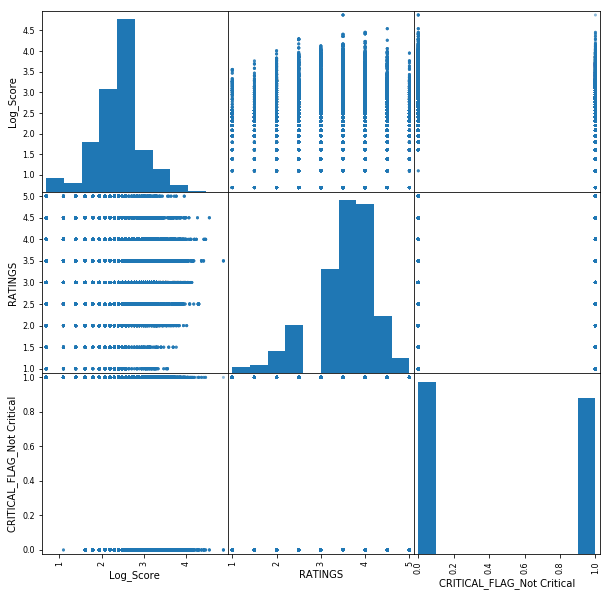

In [26]:
pd.plotting.scatter_matrix(df_lin2, alpha = 0.5, figsize = (10, 10))

### 2. Linear Regression - Log Score, Critical Flag, Zipcode, Cuisine_desc, Violation_code
### New df for linear regression

In [39]:
df_linear3_ex = df_ex.drop(['CAMIS',
                            'BORO',
                            'GRADE',
                            'DBA',
                            'VIOLATION_DESC',
                            'ACTION',
                            'INSPECTION_TYPE',
                            'GRADE_DATE',
                            'RECORD_DATE',
                            'RATINGS'
                         ], 1)

df_linear3 = df_linear3_ex[df_linear3_ex.SCORE > 0]

In [40]:
df_linear3.columns

Index(['ZIPCODE', 'CUISINE_DESC', 'VIOLATION_CODE', 'CRITICAL_FLAG', 'SCORE'], dtype='object')

In [41]:
df_linear3['Log_Score'] = df_linear3.loc[:,'SCORE'].apply(np.log)
df_linear3_1hot = pd.get_dummies(df_linear3, drop_first = True, columns = ['ZIPCODE', 
                                                                           'CUISINE_DESC', 
                                                                           'VIOLATION_CODE',
                                                                           'CRITICAL_FLAG'],)


/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
# print(list(df_linear3_1hot.columns))

In [43]:
df_lin3 = df_linear3_1hot.drop(['SCORE'], 1)

In [44]:
df_lin3_y = df_lin3['Log_Score']
df_lin3_x = df_lin3.drop(['Log_Score'], 1)


x_train3, x_test3, y_train3, y_test3 = train_test_split(df_lin3_x, df_lin3_y, test_size=0.2)

In [45]:
lr = LinearRegression()

lr.fit(x_train3, y_train3)
lr_predict3 = lr.predict(x_test3)

In [46]:
lr.score(x_test3, y_test3)

0.19012094187013617

In [47]:
print("Explained variance score/R2: %s" % skmetrics.explained_variance_score(y_test3, lr_predict3))

print("Mean squared error: %s" % skmetrics.mean_squared_error(y_test3, lr_predict3))

print("R2 score: %s" % skmetrics.r2_score(y_test3, lr_predict3))

Explained variance score/R2: 0.19023508649938536
Mean squared error: 0.23497510053132822
R2 score: 0.19012094187013617


#### Explained variance score/R2: 0.19372447507258217
#### Mean squared error: 0.2310286830766006
#### R2 score: 0.1937222246447956

### R2 score higher this time, but still produces a poor model to predict Log_Score.
### Significantly increased number of features from one-hotting also likely to have caused higher R2 score

#### Log_score is still effectively a numerical dependent variable and all of my indpendent variables are effectively categorical. 

In [36]:
cross_val_score(lr, df_lin3_x, df_lin3_y, cv=5)

array([ 1.78662644e-01,  1.87879365e-01,  1.92745473e-01, -1.03861083e+20,
       -4.69925857e+16])

In [ ]:
# Huh, is there really no correlation betwen score and any of these categories? Plot Predicted vs Actual values

In [ ]:
real_predict = pd.Series(np.exp(lr_predict3), name = 'real_predict')
real_y_test3 = pd.Series(np.exp(y_test3),name = 'real_test')


#real_y_test3['Real_Predict'] = real_predict

df_real_predict = pd.DataFrame(real_y_test3).join(real_predict)



In [ ]:
# Plot log_predicted vs log_actual values
x = lr_predict3
y = y_test3

plt.scatter(x, y)

In [ ]:
# Plot predicted vs actual values
x = real_predict
y = real_y_test3

plt.scatter(x, y)

In [ ]:
# Plot residuals of log_predicted

lr_residuals = lr_predict3 - y_test3

x = lr_predict3
y = lr_residuals

plt.scatter(x, y)

In [ ]:
# Plot residuals of actual_predicted

real_residuals = real_predict - real_y_test3

x = real_predict
y = real_residuals



In [ ]:
lr_residuals.head()

In [52]:
def kfolds_cv(x, y, n):
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    trainsets = []
    testsets = []
    for train, test in kf.split(x, y):
        trainsets.append(train)
        testsets.append(test)
    return trainsets, testsets

trainsets, testsets = kfolds_cv(x_train, y_train, 5)

In [53]:


#for i in range(0, len(trainsets)):
#    print(lr.fit(trainsets[i], testsets[i]).score)

In [ ]:
def modelprints(algo, X, y, trainfold, testfold):
    algs = algo()
    fitted_model = algs.fit(X.iloc[trainfold], y[trainfold])
    yhat = algs.predict_proba(X.iloc[testfold])
    accuracy = algs.score(X.iloc[testfold], y[testfold])
    auscore = roc_auc_score(y[testfold],yhat[:,1])
    print('for fold '+ str(i+1) + ' accuracy = ' + str(accuracy) + ' and auc score = ' + str(auscore))
    
def modelfits(algo, X, y, trainfold, testfold):
    algs = algo()
    fitted_model = algs.fit(X.iloc[trainfold], y[trainfold])
    yhat = algs.predict_proba(X.iloc[testfold])
    return yhat[:,1]

In [ ]:
for i in range(0, len(trainsets)):
    print('\nFor fold '+ str(i+1) + ':')
    print('Log Reg  : ', end='')
    modelprints(LogisticRegression(), df_lin2_x, logscore, trainsets[i], testsets[i])


Remove all grades with that are not A, B or C

In [ ]:
dfex_cols_viol = ['RATINGS', 'SCORE', 'CRITICAL_FLAG', 'GRADE', 'VIOLATION_CODE']
dfex_viol_pre = df_ex[dfex_cols_viol]


df_ex_prex = df_ex.drop(['ZIPCODE', 'CUISINE_DESC', 'URL', 'YELP_RATINGS'],
           axis = 1)



In [ ]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=dfex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=dfex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=dfex, return_type="dataframe").drop('Intercept', 1)



In [ ]:
dfex_patsy = pd.concat([dfex, grade_num_patsy, critical_flag_patsy, violation_code_patsy], 
                      axis = 1, join_axes = [dfex.index])




dfex = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG', 'VIOLATION_CODE'], 1)
dfex_viol = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG'], 1)


In [ ]:


#cuisine_desc = pd.get_dummies(df_exx['CUISINE_DESC'])
#critical_flag = pd.get_dummies(df_exx['CRITICAL_FLAG'])
#grade_num = pd.get_dummies(df_exx['GRADE'])




In [ ]:
df_exx = df_ex_prex


critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_exx, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_exx, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_exx, return_type="dataframe").drop('Intercept', 1)


#df_exx = pd.concat([df_exx, grade_num, critical_flag], axis = 1, join_axes = [df_exx.index])
df_exx = pd.concat([df_exx, 
                    grade_num_patsy, 
                    critical_flag_patsy, 
                    violation_code_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_exx = df_exx.drop(['VIOLATION_CODE', 'CRITICAL_FLAG', 'GRADE'],
           axis = 1)




In [ ]:
dfex_patsy.head()

Check each column for non numeric values

Examine data and preliminary analysis of R2

In [ ]:
sns.set_context("paper")
sns.pairplot(dfex_patsy[['SCORE','RATINGS', 'GRADE[T.B]', 'GRADE[T.C]',
       'CRITICAL_FLAG[T.Not Critical]']], kind="scatter", diag_kind="hist")


In [ ]:
dfex_patsy.rename(columns={'CRITICAL_FLAG[T.Not Critical]':'CRITICAL_FLAG[T.NotCritical]'}, inplace=True)

In [ ]:
dfex.corr()

In [ ]:
dfex_patsy

In [ ]:
y, X = patsy.dmatrices('RATINGS ~ SCORE + RATINGS + GRADE[T.B] + GRADE[T.C] + CRITICAL_FLAG[T.NotCritical]', 
                       data=dfex_patsy, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()


#lml = smf.ols('Y ')

Check R2 with LinearRegression


Legend:

dfex : [y = 'RATINGS', x = 'SCORE', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex1 : [y = 'SCORE', x ='RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex2 : [y = 'SCORE', x ='RATINGS', 'CRIT_FLAG_NUM']

dfex1_viol : [y = 'SCORE', x = 'RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

dfex2_viol : [y = 'SCORE', x = 'RATINGS', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

In [ ]:

dfex1_cols = ['SCORE', 'RATINGS', 'GRADE[T.B]', 'GRADE[T.C]', 'CRITICAL_FLAG[T.Not Critical]']
dfex1= dfex_patsy[dfex1_cols]


dfex1_viol = dfex_patsy

In [ ]:
dfex2 = dfex1.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
dfex2_viol = dfex1_viol.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)


In [ ]:
lr = LinearRegression()
X = dfex1.iloc[:, 1:]
y = dfex1.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
lr = LinearRegression(fit_intercept = True)





X = dfex2.iloc[:, 1:]
y = dfex2.SCORE
lr.fit(X,y)
lr.score(X,y)
#print('X: ', list(X))
#print(dfex2.columns)

In [ ]:
dfex2.columns

In [ ]:

X = dfex1_viol.iloc[:, 1:]
y = dfex1_viol.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
X = dfex2_viol.iloc[:, 1:]
y = dfex2_viol.iloc[:, 0]

lr.fit(X,y)
lr.score(X,y)

In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str


In [ ]:
dfex_patsy.columns

In [ ]:
dfex_patsy1 = dfex_patsy.drop(['GRADE', 'VIOLATION_CODE', 'CRITICAL_FLAG'],1 )

y_dfex2 = dfex_patsy1.SCORE
X_dfex2 = dfex_patsy1.drop(['SCORE'], 1)

model_dfex2 = sm.OLS(y_dfex2, X_dfex2)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


In [ ]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_ex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_ex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)
zipcode_patsy = patsy.dmatrix('ZIPCODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)

df_dummy_cgvz = pd.concat([df_ex, 
#                      grade_num_patsy, 
#                      critical_flag_patsy, 
#                      violation_code_patsy,
                      zipcode_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_dummy_cgvz = df_dummy_cgvz.drop(['VIOLATION_CODE', 
                                    'CRITICAL_FLAG', 
                                    'GRADE', 
                                    'ZIPCODE', 
                                    'CUISINE_DESC',
                                    'URL',
                                    'YELP_RATINGS'
                                   ],axis = 1)

df_dummy_cgvz.columns


In [ ]:
master = dfex2
#df_dummy_cgvz
y = master.SCORE
X= master.drop(['SCORE'], 1)

print(X.columns)

model_dfex2 = sm.OLS(y, X)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


In [ ]:
df_ex.columns

In [ ]:
lr = LinearRegression()

df_exx_lr= df_exx.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
X = df_exx_lr.drop(['RATINGS'], 1)
y = df_exx_lr.RATINGS

lr.fit(X, y)
lr.score(X, y)

In [ ]:
df_exx_lr.columns

In [ ]:
reg = LinearRegression()
X = df_exx.iloc[:, 1:]
y = df_exx.iloc[:, 0]
scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

In [ ]:
sns.pairplot(dfex_patsy[['SCORE', 'RATINGS','GRADE[T.B]','GRADE[T.C]','CRITICAL_FLAG[T.Not Critical]']], 
                       kind="scatter",
                       diag_kind="hist"
                       )


In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str

In [ ]:
'''y, X = patsy.dmatrices(dfex2_viol_patsy_str,
                       data=dfex2_viol, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()
'''

In [ ]:
'''df_exx_cols = ''
for i in df_exx.columns:
    df_exx_cols += i + " + "
df_exx_cols = "SCORE ~ " + df_exx_cols[8:-3] 
df_exx_cols'''

In [ ]:
'''y_df_exx, X_df_exxx = patsy.dmatrices(df_exx_cols, data=df_exx, return_type="dataframe")
model_df_exx = sm.OLS(y_df_exx, X_df_exx)
fit_df_exx = model_df_exx.fit()
fit_df_exx.summary()'''

# Violation Code

In [ ]:
df_viol = df_clean.drop(['CAMIS', 
                          'DBA',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'ZIPCODE',
                          'PHONE',
                          'CUISINE_DESC',
                          'INSPECTION_DATE',
                          'ACTION',
                          'SCORE',
                          'GRADE',
                          'GRADE_DATE',
                          'RECORD_DATE',
                          'INSPECTION_TYPE',
                          'ADDRESS',
                          'URL'
                         ], 1)
df_viol = df_viol.drop_duplicates(subset='VIOLATION_CODE')
df_viol =df_viol.sort_values(['VIOLATION_CODE'])
df_viol.head(60)


# Data Exploration 2/2

In [ ]:
df_ex.head()

In [ ]:
sns.set_context("talk")
score = dfex_viol['SCORE']
sns.distplot(score, kde = False)

In [ ]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1)

In [ ]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1, ax = (16, 30))

In [ ]:

score = dfex_viol['SCORE']
sns.distplot(score)

In [ ]:
data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])
y = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']



# Plot

In [ ]:
x =df_ex.SCORE
y = df_ex.RATINGS

sns.regplot(x, y)

In [ ]:
sns.regplot(y, x)

In [ ]:
x =df_ex.SCORE
y = df_ex.RATINGS.apply(,1)

sns.regplot(x, y)